In [70]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')
HTML('<style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import os
import sys
root_dir = './'
src_dir = os.path.join(root_dir, 'code')
sys.path = [src_dir] + sys.path

In [72]:
from RaSE import get_rfam_sequence
header, seq = get_rfam_sequence(rfam_id='RF00008', seq_id=4)
print header
print seq

AJ247121.1/133-53
UCCAGUCGAGACCUGAAGUGGGUUUCCUGACGAGGCUGUGGAGAGAGCUUUCGCUUUACUCCCGCACAAGCCGAAACUGGA


In [73]:
from RaSE import StructuralStabilityEstimator
rase = StructuralStabilityEstimator(seq, k=6, avg_bp_prob_cutoff=0.1)

In [74]:
for line in rase.transform(): print line

             ((((((.(((((((.....))))))).......(((((((((((((((....))))).))))...)).))))...))))))
  0 U G 0.63 .(((((.(((((((.....))))))).......(((((((((((((((....))))).))))...)).))))...))))). 
  1 C G 0.70 ....((((((((((.....)))))))..)))..(((((((((((((((....))))).))))...)).))))......... 
  2 C G 0.70 ....((((((((((.....)))))))..)))..(((((((((((((((....))))).))))...)).))))......... 
  3 A C 0.61 ...(((((((((((.....)))))))..)))).(((((((((((((((....))))).))))...)).))))......... 
  4 G C 0.65 ((((((((.....)).))))))..(((......(((((((((((((((....))))).))))...)).))))......))) 
  5 U G 0.85 ((((((.(((((((.....))))))))......(((((((((((((((....))))).))))...)).))))....))))) 
  6 C U 0.87 ((((((((((((((.....))))))).......(((((((((((((((....))))).))))...)).))))..))))))) 
  7 G C 0.71 ((((((..((((((.....))))))........(((((((((((((((....))))).))))...)).))))...)))))) 
  8 A C 0.36 ((((((..((((((.....))))..(((....))).((((((((((((....))))).)).))))).....))..)))))) 
  9 G C 0.72 ((((((.((.((((.....)))).))..

In [75]:
print rase.mutations

GGGCCGUCCCGGUACUUUGCCCAAGGUGAGGUGUCACCACUGUCCUCUCGGUUUAACGUGUUGCGCGCGUGGUGCUUCUCC


In [76]:
print rase.scores

[0.62597105563938105, 0.69544589516546962, 0.7037461248839959, 0.61148428809205668, 0.6488876716929759, 0.84930699735195514, 0.87391858375771336, 0.7122252791083632, 0.36156580891999651, 0.71882505459584967, 0.31922974971425588, 0.3569754185172932, 0.27674656490545541, 0.89700279863513488, 0.83006458276558637, 0.87197262108386242, 0.87640563406990801, 0.94790536635510469, 0.92172423418992167, 0.72047175487868487, 0.58415443786846433, 0.63628675805254431, 0.26241275522855051, 0.67908065461510203, 0.58985066098505834, 0.64577696953152663, 0.73701518381935571, 0.64242886377093011, 0.96088524329327329, 0.68232247988670958, 0.88228616368674984, 0.82596642934369457, 0.75865480054191348, 0.73924588871467012, 0.73546045000233251, 0.54061163518804989, 0.65013985950351472, 0.2802987168273664, 0.78670474452857109, 0.70778188445437695, 0.69728112846356116, 0.70650277644257009, 0.76091965573100229, 0.55265370384015799, 0.31223241688210718, 0.6866701310599953, 0.67623428524094797, 0.6682960221605103

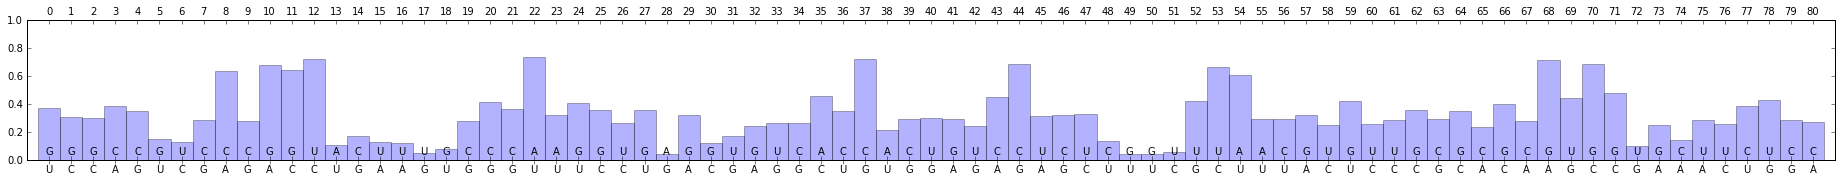

In [77]:
rase.plot()

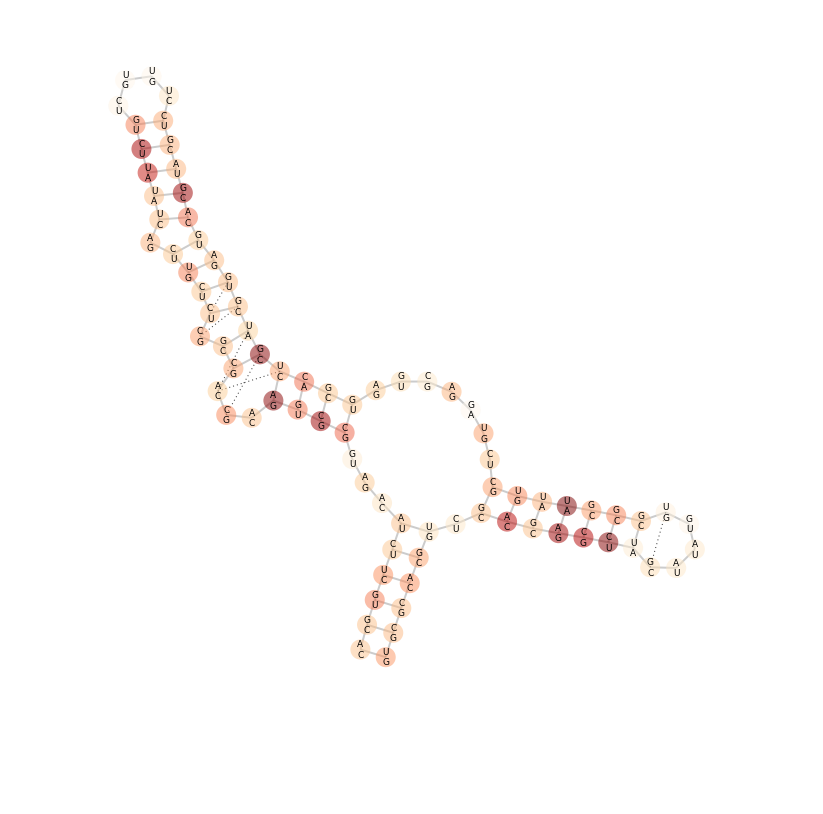

In [78]:
rase.draw()

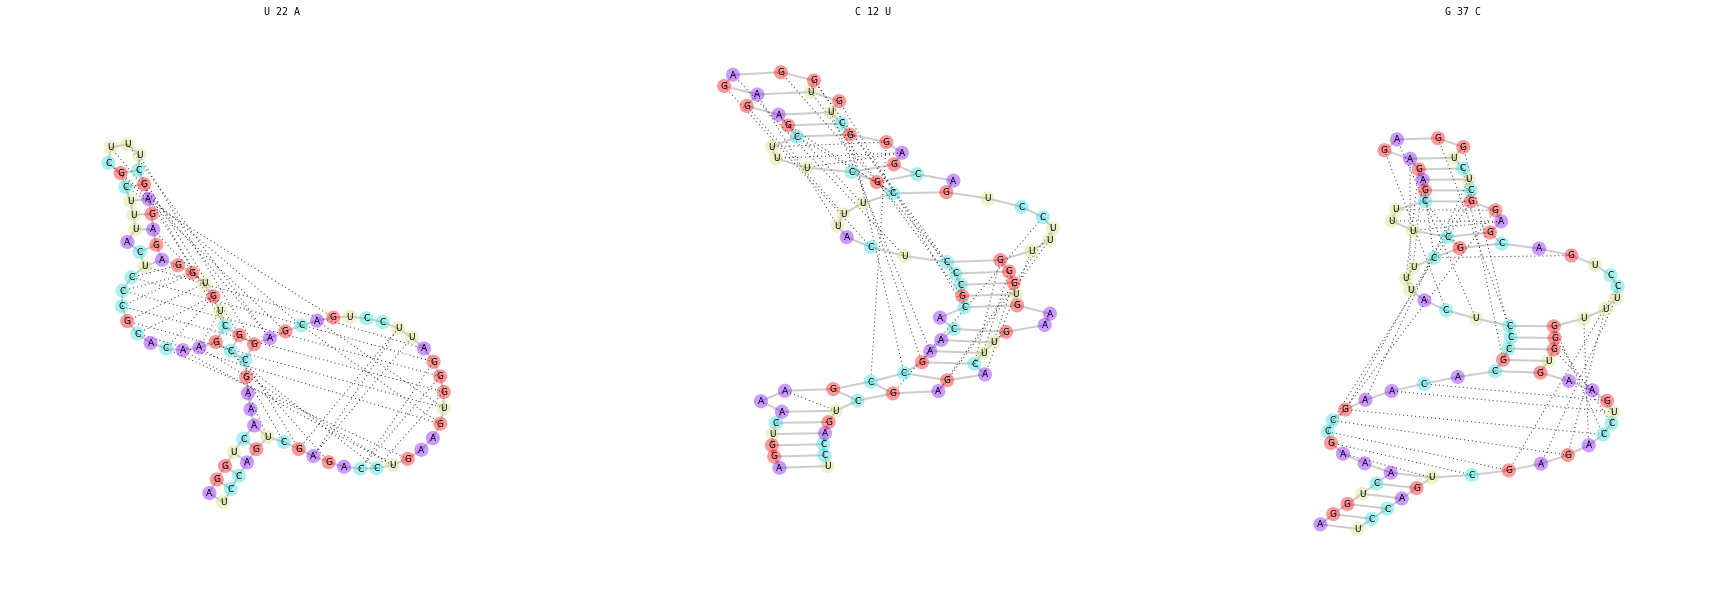

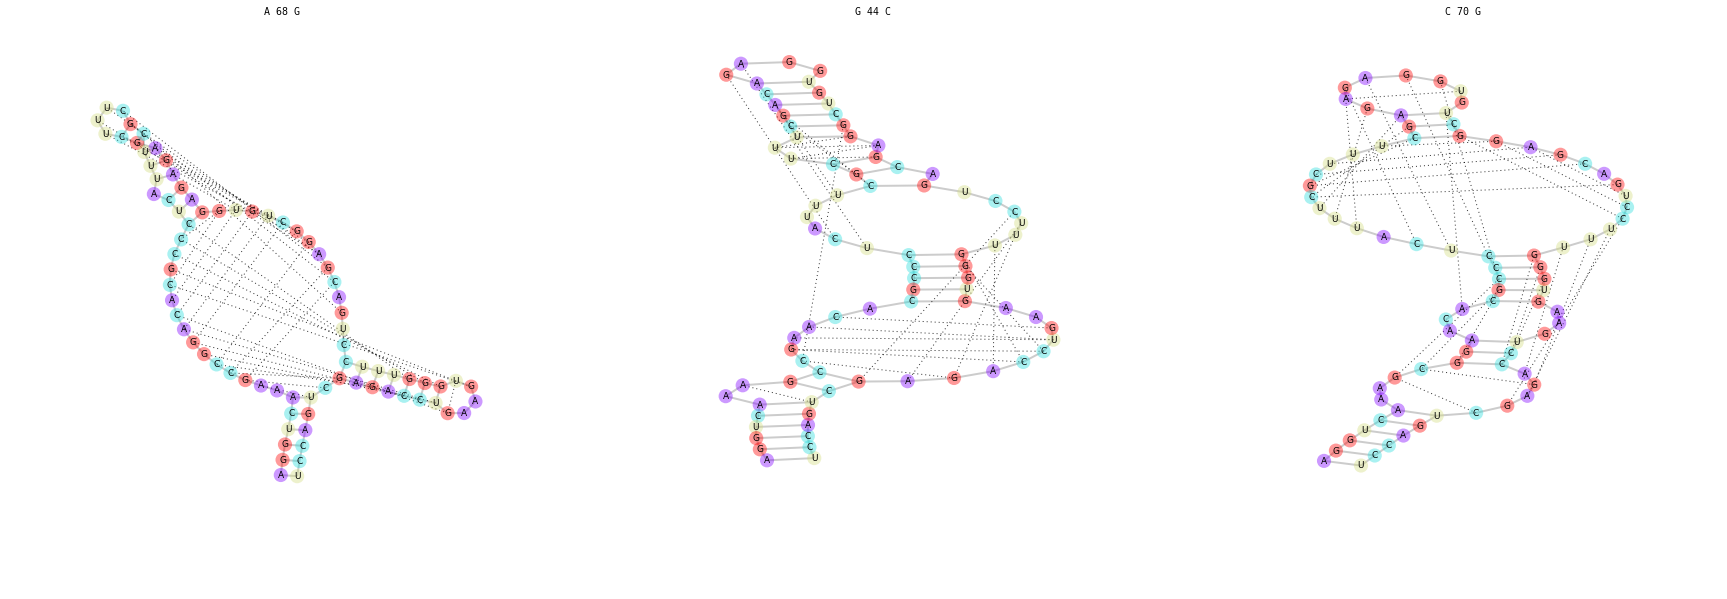

In [79]:
rase.draw_all()

---